<a href="https://colab.research.google.com/github/marcellinusc/solar-radiation/blob/model-building/ml_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#@title Run on TensorFlow 2.x

%tensorflow_version 2.x
from __future__ import absolute_import, division
from __future__ import print_function, unicode_literals

In [2]:
#@title Import relevant modules

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers
from matplotlib import pyplot as plt

# The following lines adjust the granularity of reporting. 
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format

print('Imported')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Imported


In [3]:
#@title Load raw dataset
data = pd.read_csv('https://raw.githubusercontent.com/marcellinusc/solar-radiation/data-prep/datasets.csv')
print('Dataset length:', str(len(data)))

Dataset length: 32686


In [4]:
#@title Exclude raw data between sunset-sunrise

daylight = [data['Time'].values[x] > data['Sunrise'].values[x]
            and data['Time'].values[x] < data['Sunset'].values[x]
            for x in range(len(data))]
data['Daylight'] = daylight
data['Daylight'] = data['Daylight'].astype('float')

# Clean raw dataset from daylight value of 0
data = data[data.Daylight != 0]

print('Dataset length:', str(len(data)))

Dataset length: 15608


In [5]:
#@title Convert UNIX time format to UTC

data["TimeConversion"] = pd.to_datetime(data["Time"], format="%H:%M:%S")

# Get the month of the year and the day of the month
data["Month"] = pd.to_datetime(data["UNIXTime"].astype(int),
                               unit="s").dt.month
data["Day"] = pd.to_datetime(data["UNIXTime"].astype(int),
                             unit="s").dt.day 

# Get the hour and the minute of the day
data["Hour"] = pd.to_datetime(data["TimeConversion"],
                              format="%H:%M:%S").dt.hour
data["Minute"] = pd.to_datetime(data["TimeConversion"],
                              format="%H:%M:%S").dt.minute

print('Converted')

Converted


In [6]:
#@title Divide clean dataset into training set and test set

# Sort dataset in descending order from the latest to the earliest
data['Data'] = pd.to_datetime(data['Data'])
data = data.sort_values(by=['Data', 'Time'], ascending=False)

# Percentage of dataset to be considered as test set
test_split = 0.2
data_test = data[:][0:round((len(data)*test_split))]
data_train = data[:][round((len(data)*test_split)):]
# Shuffle training set
data_train = data_train.reindex(np.random.permutation(data_train.index))

print('Training set length:', str(len(data_train)),
      '\nTest set length:', str(len(data_test)))

# Remove column 'Daylight' from dataframe
data_train = data_train.drop(columns='Daylight')
data_test = data_test.drop(columns='Daylight')

Training set length: 12486 
Test set length: 3122


In [7]:
#@title Normalize values

# Calculate the Z-scores of each column in the training set:
data_train_mean = data_train.select_dtypes(include=['float64', 'int64']).mean()
data_train_std = data_train.select_dtypes(include=['float64', 'int64']).std()
data_train_norm = (data_train.select_dtypes(include=['float64', 'int64']) 
                   - data_train_mean)/data_train_std

# Calculate the Z-scores of each column in the test set.
data_test_mean = data_test.select_dtypes(include=['float64', 'int64']).mean()
data_test_std = data_test.select_dtypes(include=['float64', 'int64']).std()
data_test_norm = (data_test.select_dtypes(include=['float64', 'int64'])
                  - data_test_mean)/data_test_std

print("Normalized")

Normalized


In [8]:
#@title Represent features as a floating-point value

feature_columns = []

temperature = tf.feature_column.numeric_column("Temperature")
feature_columns.append(temperature)

pressure = tf.feature_column.numeric_column("Pressure")
feature_columns.append(pressure)

humidity = tf.feature_column.numeric_column("Humidity")
feature_columns.append(humidity)

wdirection = tf.feature_column.numeric_column("WindDirection")
feature_columns.append(wdirection)

wspeed = tf.feature_column.numeric_column("WindSpeed")
feature_columns.append(wspeed)

#sunrise = tf.feature_column.numeric_column("Sunrise")
#feature_columns.append(sunrise)

#sunset = tf.feature_column.numeric_column("Sunset")
#feature_columns.append(sunset)

#month = tf.feature_column.numeric_column("Month")
#feature_columns.append(month)

#day = tf.feature_column.numeric_column("Day")
#feature_columns.append(day)

hour = tf.feature_column.numeric_column("Hour")
feature_columns.append(hour)

#minute = tf.feature_column.numeric_column("Minute")
#feature_columns.append(minute)

# Convert the list of feature columns into a layer that 
# later will be fed into the model. 
feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

print('Represented')

Represented


In [9]:
#@title Define plotting function

def plot_the_loss_curve(epochs, rmse_training, rmse_validation):
  """Plot loss vs epoch in a graph"""
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Root Mean Squared Error')

  plt.plot(epochs[1:], rmse_training[1:], label='Training Loss')
  plt.plot(epochs[1:], rmse_validation[1:], label='Validation Loss')
  plt.legend()

  merged_rmse_lists = rmse_training[1:] + rmse_validation[1:]
  highest_loss = max(merged_rmse_lists)
  lowest_loss = min(merged_rmse_lists)
  delta = highest_loss - lowest_loss
  print(delta)

  top_of_y_axis = highest_loss + (delta * 0.05)
  bottom_of_y_axis = lowest_loss - (delta * 0.05)
  plt.ylim([bottom_of_y_axis, top_of_y_axis])
  plt.show()  

print('Defined')

Defined


In [10]:
#@title Define functions to create and train a linear regression model

def create_model(learning_rate, feature_layer):
  """Create and compile a simple linear regression model."""

  # Most simple tf.keras models are sequential.
  model = tf.keras.models.Sequential()

  # Add the layer containing the feature columns to the model.
  model.add(feature_layer)

  # Add one linear layer to the model to yield a simple linear regressor.
  model.add(tf.keras.layers.Dense(units=1, input_shape=(1,)))

  # Construct the layers into a model that TensorFlow can execute.
  model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=learning_rate),
                loss='mean_squared_error',
                metrics=[tf.keras.metrics.RootMeanSquaredError()])
  
  return model           


def train_model(model, dataset, epochs, batch_size,
                label_name, validation_split):
  """Feed a dataset into the model in order to train it."""

  # Split the dataset into features and label.
  features = {name:np.array(value) for name, value in dataset.items()}
  label = np.array(features.pop(label_name))
  history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, validation_split=validation_split, 
                      shuffle=True)

  # Get details that will be useful for plotting the loss curve.
  epochs = history.epoch
  hist = pd.DataFrame(history.history)
  rmse = hist['root_mean_squared_error']

  return epochs, rmse, history.history   

print('Defined')

Defined


Epoch 1/100

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

7/7 [==============================] - 0s 37ms/step - loss: 2.9402 - root_mean_squared_error: 1.7289 - val_loss: 2.4078 - val_root_mean_squared_error: 1.5750
Epoch 2/100
7/7 [==============================] - 0s 10ms/step - loss: 2.2853 - root_mean_squared_error: 1.5225 - val_loss: 1.9956 - val_root_mean_squared_error: 1.4317
Epoch 3/100
7/7 [==============================] - 0s 10ms/step - loss: 1.9131 - root_mean_squared_error: 1.3897 - val_loss: 1.6971 - val_root_mean_squared_error: 1.318

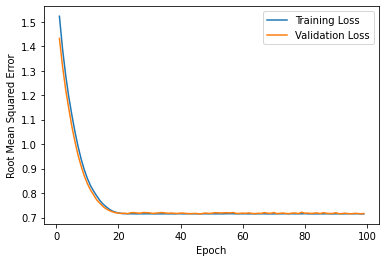


 Evaluate the linear regression model against the test set:
4/4 [==============================] - 0s 2ms/step - loss: 0.4858 - root_mean_squared_error: 0.7276


[0.4858439564704895, 0.727607250213623]

In [11]:
#@title Train model as linear regression

# The following variables are the hyperparameters.
learning_rate = 0.01
epochs = 100
batch_size = 1024
validation_split = 0.5
label_name = "Radiation"
 
# Establish the model's topography.
model = create_model(learning_rate, feature_layer)

# Train the model on the normalized training set.
epochs, rmse, history = train_model(model, data_train_norm, epochs, batch_size,
                                    label_name, validation_split=validation_split)
plot_the_loss_curve(epochs, history["root_mean_squared_error"], 
                    history["val_root_mean_squared_error"])

test_features = {name:np.array(value) for name, value in data_test_norm.items()}
# Isolate the label
test_label = np.array(test_features.pop(label_name))
print("\n Evaluate the linear regression model against the test set:")
model.evaluate(x=test_features, y=test_label, batch_size=batch_size)